## Deep Neural Network model
*Summary:* We model an IDS with a deep neural network model using feature selection from PCA analysis. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# train = pd.read_csv("/content/drive/MyDrive/UNSWNB15/UNSW_NB15_training-set.csv")
# test = pd.read_csv("/content/drive/MyDrive/UNSWNB15/UNSW_NB15_testing-set.csv")

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

In [2]:
from sklearn.preprocessing import MinMaxScaler

data = pd.concat([train, test]).reset_index(drop=True)
data = data.drop(columns=["id"], axis=1)

# get numeric column names without label column
num_cols = data._get_numeric_data().columns[:-1]

# subract numeric columns and 'attack_cat' column from all columns to get categorical columns 
cat_cols = list(set(data.columns) - set(num_cols))

print(f"Numerical features: {len(num_cols)}\nCategorical features: {len(cat_cols)}")

y_df_dummies = pd.get_dummies(data.iloc[:, -2:-1])

data[cat_cols] = data[cat_cols].astype('category')
for cat in cat_cols:
    data[cat] = data[cat].cat.codes

y_df = data.iloc[:, -2:-1]

# apply min-max scaler that scales the variables in the range [0-1]
scl = MinMaxScaler()
data = pd.DataFrame(scl.fit_transform(data.iloc[:, :-2]), columns=data.columns[:-2])

(data.shape, y_df.shape)

Numerical features: 39
Categorical features: 5


((257673, 42), (257673, 1))

In [3]:
from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import homogeneity_score
from sklearn import metrics

X_df = data
true_labels = y_df.to_numpy().flatten().tolist()

n = len(X_df.columns)
HS = []

for i in range(n):
    c = KMeans(init='k-means++', n_init=10, n_clusters=10, random_state=42).fit_predict(X=X_df.iloc[:, i].to_frame())
    HS.append(metrics.homogeneity_score(true_labels, c))


c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due 

In [4]:
rnk = np.argsort(np.array(HS))

In [6]:
HS

[0.0660824717139018,
 0.1784242810116429,
 0.2768750943824372,
 0.1861055695465157,
 0.03275095523667059,
 0.04216630739466409,
 0.00896894488463706,
 0.024101785064552243,
 0.17603159097741836,
 0.23642205253857246,
 0.25948064420829586,
 0.19616924535142738,
 0.09646186521352008,
 0.012756954098506431,
 0.036106324441655686,
 0.01366638540167971,
 0.04464147473832232,
 0.032906489455632286,
 0.022886429789776643,
 0.11751515173922225,
 0.10259214888609472,
 0.10269631302899102,
 0.11178339577672118,
 0.09193077681201624,
 0.06762818019849628,
 0.07887957408364173,
 0.16400777317522375,
 0.20682009783500332,
 0.02065963776468419,
 0.0030323231451381337,
 0.22256246071963218,
 0.2684045503253643,
 0.2167245933280385,
 0.2361395077080385,
 0.27109539245999514,
 0.21005535325051944,
 0.004743833501047486,
 0.004742782579760852,
 0.022993945934405766,
 0.177853910870278,
 0.23468787043122932,
 0.008720858908669367]

In [54]:
from sklearn.model_selection import StratifiedKFold

kfolds = StratifiedKFold(n_splits=5, shuffle=True)

In [74]:
from tensorflow.keras import layers, Sequential

smr=[]
for j in range(rnk.shape[0]):
    fd = X_df.iloc[:,rnk[j:]]
    pp = 0
    for train,test in kfolds.split(fd, y_df):
        
        model = Sequential()
        model.add(layers.Dense(128, activation='relu', input_dim=fd.shape[1], use_bias=True))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(64, activation='relu', use_bias=True))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation='relu', use_bias=True))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(10, activation='softmax', use_bias=True))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        # Fit data to model
        model.fit(fd.iloc[train], y_df_dummies.iloc[train],
                    batch_size=1000,
                    epochs=10,
                    verbose=0)

        # Generate generalization metrics
        scores = model.evaluate(fd.iloc[test], y_df_dummies.iloc[test], verbose=0)
        # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        pp += (scores[1] * 100)

    pp=pp/kfolds.n_splits
    smr.append([j, pp])
    print(smr)


[[0, 76.46667838096619]]
[[0, 76.46667838096619], [1, 76.54624342918396]]
[[0, 76.46667838096619], [1, 76.54624342918396], [2, 76.53615593910217]]
[[0, 76.46667838096619], [1, 76.54624342918396], [2, 76.53615593910217], [3, 76.44922375679016]]
[[0, 76.46667838096619], [1, 76.54624342918396], [2, 76.53615593910217], [3, 76.44922375679016], [4, 76.99642658233643]]
[[0, 76.46667838096619], [1, 76.54624342918396], [2, 76.53615593910217], [3, 76.44922375679016], [4, 76.99642658233643], [5, 76.82333707809448]]
[[0, 76.46667838096619], [1, 76.54624342918396], [2, 76.53615593910217], [3, 76.44922375679016], [4, 76.99642658233643], [5, 76.82333707809448], [6, 76.87029600143433]]


KeyboardInterrupt: 

In [22]:
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)

def train_test_n_fold(inputs, targets):

    acc_per_fold = 0
    for train, test in kfold.split(inputs, targets):
        # Generate a print
        # print('------------------------------------------------------------------------')
        # print(f'Training for fold {fold_no} ...')

        # Define the model architecture
        model = Sequential()
        model.add(layers.Dense(128, activation='relu', input_dim=inputs.shape[1]), use_bias=True)
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(64, activation='relu', input_dim=128), use_bias=True)
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation='relu', input_dim=64), use_bias=True)
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(10, activation='softmax'), use_bias=True)

        # Compile the model
        model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        # Fit data to model
        model.fit(inputs.iloc[train], targets.iloc[train],
                    batch_size=1000,
                    epochs=10,
                    verbose=0)

        # Generate generalization metrics
        scores = model.evaluate(inputs.iloc[test], targets.iloc[test], verbose=0)
        # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold += (scores[1] * 100)

        # Increase fold number
        # fold_no = fold_no + 1
        
    return acc_per_fold/5


In [12]:
import copy

ranking = copy.deepcopy(HS)
ranking.sort(key=lambda x: x[1], reverse=True)

inputs = X_df.copy(deep=True)
targets = y_df_dummies

acc = []

for i in range(n):
    fd=x[:,Rnk[j:]]
    # val = ranking.pop()
    # print(val, len(ranking))
    # inputs = inputs.drop(inputs.columns[val[0]], axis=1)
    # acc.append((i, train_test_n_fold(inputs=inputs, targets=targets)))

acc

(29, 0.0030323231451381337) 41


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [70]:
from sklearn.metrics.cluster import homogeneity_score

homogeneity_score(true_labels.to_numpy().flatten().tolist(), kmeans.labels_.reshape(-1,))

# kmeans.labels_.reshape(-1,1).shape


c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


0.1784242810116429

In [57]:
from sklearn.model_selection import train_test_split

y = pd.get_dummies(data['attack_cat'])
X = data.iloc[:, :-2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((172640, 42), (85033, 42), (172640, 10), (85033, 10))

# Sklearn MLP model

In [28]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    activation='relu',
    solver='adam', 
    hidden_layer_sizes=(128, 64, 32)
)

model = mlp.fit(X_train, y_train)

c:\Users\janba\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
model.score(X_test, y_test)

0.7482741994284572

# Tensorflow model

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [59]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [60]:
model = keras.Sequential(
    [
        layers.Dense(128, activation='relu', input_dim=42),
        layers.Dense(64, activation='relu', input_dim=128),
        layers.Dense(32, activation='relu', input_dim=64),
        layers.Dense(10, activation='softmax')
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               5504      
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 16,170
Trainable params: 16,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=1000)

In [41]:
model.compile('adam', loss='categorical_crossentropy', metrics='accuracy', )

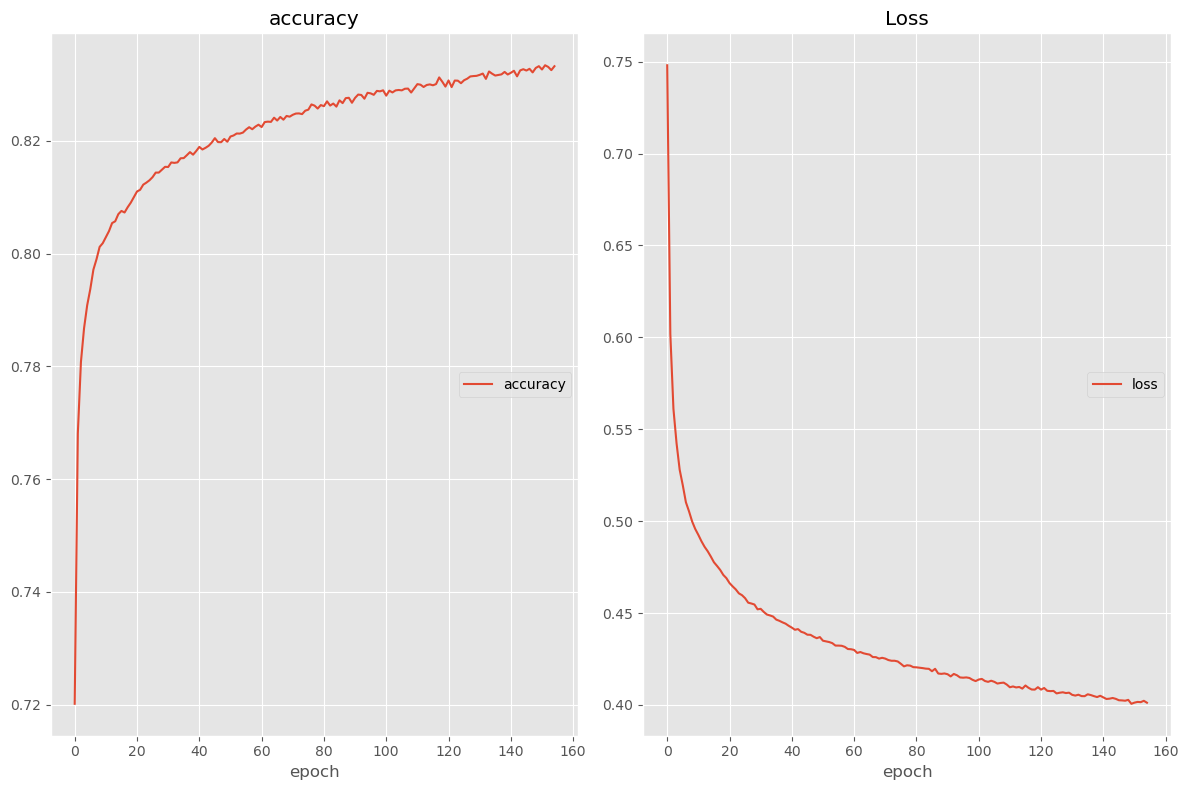

accuracy
	accuracy         	 (min:    0.720, max:    0.833, cur:    0.833)
Loss
	loss             	 (min:    0.401, max:    0.748, cur:    0.401)


In [42]:
monitor_val_acc = EarlyStopping(monitor='loss', patience=5)

model.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=128, 
    callbacks=[PlotLossesKeras(), monitor_val_acc], 
    shuffle=1000, 
    verbose=0
)

In [43]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 3s 933us/step - loss: 0.4440 - accuracy: 0.8220


[0.4439775049686432, 0.8219985365867615]